In [12]:
!curl -L -A "Mozilla/5.0" -o corpes_lemas.zip https://www.rae.es/corpes/assets/rae/files/corpes/corpes_lemas.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.8M  100 14.8M    0     0  10.3M      0  0:00:01  0:00:01 --:--:-- 10.3M


In [13]:
import zipfile, os

with zipfile.ZipFile("corpes_lemas.zip", "r") as zip_ref:
    zip_ref.extractall()

os.remove("corpes_lemas.zip")

In [14]:
import pandas, re

csv_output = "corpes_lemas_clean.csv"
dataset = "frecuencia_lemas_corpes_1_3.txt"

with open(dataset, "r", encoding="utf-8") as f:
    lines = f.readlines()

clean_rows = []

# Expresión regular para extraer los campos ignorando etiquetas como T, P, etc.
for line in lines:
    match = re.match(r'^(.+?)\s+[A-Z]\s+([\d.,]+)\s+([\d.,]+)\s+([\d.,]+)', line)
    if match:
        element = match.group(1).strip()
        freq_signs = float(match.group(2).replace(",", "").replace(".", ""))
        freq_sin_signs = float(match.group(3).replace(",", ""))
        freq_normal = float(match.group(4).replace(",", ""))
        clean_rows.append([element, freq_signs, freq_sin_signs, freq_normal])

corpes_df = pandas.DataFrame(clean_rows, columns=[
    "element",
    "frequency_signs",       # Frecuencia con signos ortográficos
    "frequency_no_signs",    # Frecuencia sin signos ortográficos
    "frequency"              # Frecuencia normal
])

corpes_df

,element,frequency_signs,frequency_no_signs,frequency
0,el,49657748.0,98648.64,113671.32
1,de,31062445.0,61707.75,71104.90
2,",",27823866.0,55274.08,63691.48
3,.,18660077.0,37069.56,42714.69
4,y,12468265.0,24769.09,28541.04
...,...,...,...,...
2004486,dos mil veintinueve,1.0,0.00,0.00
2004487,siete mil doscientos noventa y un,1.0,0.00,0.00
2004488,Sevilla Granada,1.0,0.00,0.00
2004489,Raúl Tejón Fernando Gil,1.0,0.00,0.00


In [15]:
# Eliminar filas donde la frecuencia normal es 0
corpes_df = corpes_df[corpes_df["frequency"] != 0]

# Guardar CSV limpio
corpes_df.to_csv(csv_output, index=False)

corpes_df

,element,frequency_signs,frequency_no_signs,frequency
0,el,49657748.0,98648.64,113671.32
1,de,31062445.0,61707.75,71104.90
2,",",27823866.0,55274.08,63691.48
3,.,18660077.0,37069.56,42714.69
4,y,12468265.0,24769.09,28541.04
...,...,...,...,...
378210,Niceaunties,5.0,0.00,0.01
378211,KM3NET,5.0,0.00,0.01
378212,Nejliúdov,5.0,0.00,0.01
378213,Gómez-Hurtado,5.0,0.00,0.01


In [ ]:


import math
import functools
import itertools

import collections
import matplotlib.pyplot

In [16]:
import unidecode

def transliterate(string):
    if 0 < len(string) < 64:
        string = re.sub(r"[^\x20-\x7E]", "", unidecode.unidecode(string.title()))
        return {string, string.replace(chr(32), "")}
    return {}

transliterate("gabriel garcía márquez")

{'Gabriel Garcia Marquez', 'GabrielGarciaMarquez'}

In [17]:
transliterated_data = []
for row in corpes_df.itertuples(index=False):
    transliterations = transliterate(row.element)
    for transliteration in transliterations:
        if transliteration:
            transliterated_data.append([transliteration, row.frequency])
corpes_df_tr = pandas.DataFrame(transliterated_data, columns=["transliterated", "frequency"])
corpes_df_tr

,transliterated,frequency
0,El,113671.32
1,De,71104.90
2,",",63691.48
3,.,42714.69
4,Y,28541.04
...,...,...
481862,Niceaunties,0.01
481863,Km3Net,0.01
481864,Nejliudov,0.01
481865,Gomez-Hurtado,0.01


In [7]:
transliterations = corpes_df_tr.groupby("transliterated")["frequency"].sum().sort_values(ascending=False)
transliterations

transliterated
El                    116683.39
De                     71150.38
,                      63691.48
.                      42714.69
Que                    32167.34
                        ...    
Fanor Trochez Zoto         0.00
Fanor Tellez               0.00
Fanor Nava                 0.00
Fanor Mondragon            0.00
~Payaso                    0.00
Name: frequency, Length: 2582646, dtype: float64

In [23]:
transliteration_length = pandas.Series(transliterations.index.str.len())
mean_length = transliteration_length.mean()
std_length = transliteration_length.std()
mean_length, std_length

(np.float64(12.451754905627794), 5.420332952525103)

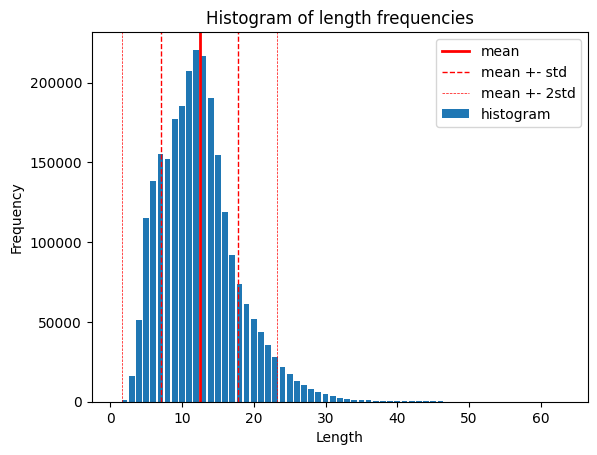

In [24]:
histogram = transliteration_length.value_counts().sort_index()
matplotlib.pyplot.bar(histogram.index, histogram, label="histogram")
matplotlib.pyplot.axvline(x=mean_length-(std_length*2), color="red", linestyle="--", linewidth=0.5)
matplotlib.pyplot.axvline(x=mean_length-std_length, color="red", linestyle="--", linewidth=1)
matplotlib.pyplot.axvline(x=mean_length, color="red", linestyle="-", label="mean", linewidth=2)
matplotlib.pyplot.axvline(x=mean_length+std_length, color="red", linestyle="--", label="mean +- std",linewidth=1)
matplotlib.pyplot.axvline(x=mean_length+(std_length*2), color="red", linestyle="--", label="mean +- 2std",linewidth=0.5)
matplotlib.pyplot.title("Histogram of length frequencies")
matplotlib.pyplot.ylabel("Frequency")
matplotlib.pyplot.xlabel("Length")
matplotlib.pyplot.legend()
matplotlib.pyplot.show()

In [25]:
min_length = 1
max_length = round((mean_length - min_length) * 2)
(min_length, max_length)

(1, 23)

In [26]:
transliterations = transliterations[transliterations.index.str.len() < max_length]
transliterations

,frequency
transliterated,
El,116683.39
De,71150.38
",",63691.48
.,42714.69
Que,32167.34
...,...
FanorTellez,0.00
FanorTrochezZoto,0.00
FanorVillarroel,0.00


In [27]:
transliteration_length = transliterations.index.str.len()
transliteration_length

Index([ 2,  2,  1,  1,  3,  1,  2,  1,  2,  3,
       ...
        8, 16, 11, 14,  9, 11, 16, 15, 12, 13],
      dtype='int64', name='transliterated', length=2456454)

In [28]:
transliteration_length_counts = transliteration_length.value_counts().sort_index()
transliteration_length_counts

,count
transliterated,
1,66
2,1285
3,16414
4,50971
5,115172
6,138273
7,155153
8,152053
9,177140


In [29]:
length_frequency_distribution = (transliteration_length_counts / transliteration_length_counts.sum()).sort_index()
length_frequency_distribution

,count
transliterated,
1,0.000027
2,0.000523
3,0.006682
4,0.020750
5,0.046885
6,0.056290
7,0.063161
8,0.061899
9,0.072112


In [30]:
length_frequencies_sum = transliterations.groupby(transliteration_length).sum().sort_index() / 1000000
length_frequencies_sum

,frequency
transliterated,
1,0.199872
2,0.305483
3,0.119355
4,0.083564
5,0.110012
6,0.085020
7,0.079022
8,0.065012
9,0.046206


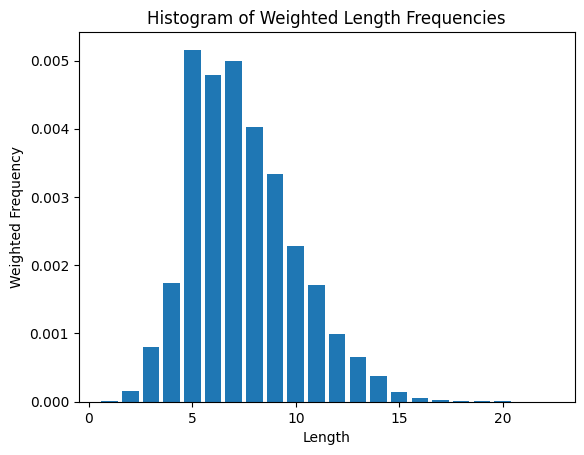

In [31]:
weighted_frequency_sum = length_frequency_distribution * length_frequencies_sum
matplotlib.pyplot.bar(weighted_frequency_sum.index, weighted_frequency_sum, label="histogram")
matplotlib.pyplot.title("Histogram of Weighted Length Frequencies")
matplotlib.pyplot.ylabel("Weighted Frequency")
matplotlib.pyplot.xlabel("Length")
matplotlib.pyplot.show()

In [32]:
levels = 3
max_permutation_sum = math.ceil(mean_length) * levels
max_permutation_sum

39

In [33]:
permutations_strs = []
permutation_frequencies = []

for level in range(1, levels+1):
    permutations = itertools.product(range(min_length, max_length), repeat=level)
    for permutation in permutations:
        permutation_sum = sum(permutation)
        if 8 <= permutation_sum <= max_permutation_sum:
            permutation_frequencies.append(sum(weighted_frequency_sum[num]*num/permutation_sum for num in permutation) * 1/len(permutation))
            permutations_strs.append(" ".join(str(num) for num in permutation))
weighted_permutations = pandas.Series(permutation_frequencies, index=permutations_strs).sort_values(ascending=False)
weighted_permutations

,0
8,4.024226e-03
9,3.331979e-03
5 5,2.578978e-03
5 7,2.530316e-03
7 5,2.530316e-03
...,...
22 1,6.420519e-07
1 22,6.420519e-07
1 1 22,4.847852e-07
1 22 1,4.847852e-07


In [34]:
ratios = [1.0] + [n / 10**i for n in range(1, 10) for i in range(1, 4)]
ratios = sorted(ratios)
ratios

[0.001,
 0.002,
 0.003,
 0.004,
 0.005,
 0.006,
 0.007,
 0.008,
 0.009,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1,
 0.2,
 0.3,
 0.4,
 0.5,
 0.6,
 0.7,
 0.8,
 0.9,
 1.0]

In [36]:
def depth(ratio):
    lower_bound = transliterations.quantile(1.0 - ratio)
    transliterations_ratio = transliterations[transliterations >= lower_bound].index
    return transliterations_ratio.to_series().groupby(transliterations_ratio.str.len()).apply(list).to_dict()

depth_ratios = {depth_ratio: depth(depth_ratio) for depth_ratio in ratios}

In [37]:
def scope(ratio):
    lower_bound = weighted_permutations.quantile(1.0 - ratio)
    permutations_ratio = weighted_permutations[weighted_permutations >= lower_bound].index
    return [tuple(map(int, permutation.split())) for permutation in permutations_ratio]

scope_ratios = {scope_ratio: scope(scope_ratio) for scope_ratio in ratios}

In [38]:
def estimate(depth_ratio, scope_ratio):
    depth_ratio = {length: len(transliteration_list) for length, transliteration_list in depth_ratios[depth_ratio].items()}
    scope_ratio = scope_ratios[scope_ratio]
    permutation_sum = 0
    for permutation in scope_ratio:
        if all(num in depth_ratio for num in permutation):
            permutation_sum += functools.reduce(lambda x, y: x * y, [depth_ratio[num] for num in permutation])
    return permutation_sum

depth_scope_ratios = {(depth_ratio, scope_ratio): estimate(depth_ratio, scope_ratio) for depth_ratio in depth_ratios for scope_ratio in scope_ratios}

In [39]:
rules = [":", "l", "u"]

with open("rules/transliterating.rule", "w") as file:
    file.write("\n".join(rules) + "\n")

FileNotFoundError: [Errno 2] No such file or directory: 'rules/transliterating.rule'

In [ ]:
hourly_max_estimate = 50000 * 60 * 60 / len(rules)
hourly_max_estimate

60000000.0

In [ ]:
def best_estimate(hourly_max_estimate, hours=1, criterion="depthscope"):
    estimates = []
    for depth_scope_ratio, ratio_estimate in depth_scope_ratios.items():
        if ratio_estimate <= hourly_max_estimate*hours:
            depth_ratio, scope_ratio = depth_scope_ratio
            estimates.append({
                "depth": depth_ratio,
                "scope": scope_ratio,
                "hours": depth_scope_ratios[depth_scope_ratio]/hourly_max_estimate,
                "depthscope": depth_ratio*scope_ratio
            })
    return tuple(max(estimates, key=lambda x: x[criterion]).items())

day_estimates = collections.Counter(best_estimate(hourly_max_estimate, i+1) for i in range(24)).most_common(1)[0]
day_estimate = dict(day_estimates[0])
day_estimate

{'depth': 0.01,
 'scope': 0.007,
 'hours': 6.565286733333333,
 'depthscope': 7.000000000000001e-05}

In [ ]:
depth_str = day_estimate["depth"]
scope_str = day_estimate["scope"]
day_str = round(day_estimates[1]/24, 1)
hours_str = round(day_estimate["hours"])

file_name = f"depth{depth_str:.0e}scope{scope_str:.0e}day{day_str:.0e}hours{hours_str}"
file_name

'depth1e-02scope7e-03day3e-01hours7'

In [ ]:
def wordlist(depth_ratio, scope_ratio, file_name):
    with open(f"wordlists/{file_name}.txt", "w") as file:
        for permutation in scope_ratios[scope_ratio]:
            for permutation_tuple in itertools.product(*[depth_ratios[depth_ratio][num] for num in permutation]):
                file.write("".join(permutation_tuple) + "\n")

wordlist(day_estimate["depth"], day_estimate["scope"], file_name)

KeyboardInterrupt: 